# Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import os
import pathlib
import sys

# 3rd party libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa

# Local libraries
import pudl

In [3]:
sns.set()
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,4)
mpl.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Define Functions & Constants

## Notebook Constants

In [5]:
PRIME_MOVER_CODE_MAP = {
    "BA": "battery_storage",
    "BT": "binary_cycle_turbine",
    "CA": "combined_cycle_steam_part",
    "CC": "combined_cycle_total_unit",
    "CE": "compressed_air_storage",
    "CP": "concentrated_solar_storage",
    "CS": "combined_cycle_single_shaft",
    "CT": "combined_cycle_combustion_turbine",
    "ES": "other_energy_storage",
    "FC": "fuel_cell",
    "FW": "flywheel_storage",
    "GT": "gas_combustion_turbine",
    "HA": "hydrokinetic_axial_flow_turbine",
    "HB": "hydrokinetic_wave_buoy",
    "HK": "other_hydrokinetic",
    "HY": "hydraulic_turbine",
    "IC": "internal_combustion_engine",
    "PS": "pumped_hydraulic_storage",
    "OT": "other",
    "ST": "steam_turbine",
    "PV": "photovoltaic",
    "WT": "onshore_wind_turbine",
    "WS": "offshore_wind_turbine",
}

FOSSIL_PRIME_MOVERS = {
    "CT": "combined_cycle_combustion_turbine",
    "CS": "combined_cycle_single_shaft",
    "CA": "combined_cycle_steam_part",
    "CC": "combined_cycle_total_unit",
    "GT": "gas_combustion_turbine",
    "IC": "internal_combustion_engine",
    "ST": "steam_turbine",
}

GENS_COLS = [
    "report_date",
    "plant_id_eia",
    "plant_name_eia",
    "unit_id_pudl",
    "generator_id",
    "capacity_mw",
    "prime_mover_code",
    "energy_source_code_1",
    "energy_source_code_2",
    "fuel_type_code_pudl",
    "technology_description",
    "associated_combined_heat_power",
]

START_DATE, END_DATE = ("2009-01-01", "2019-01-01")


## `prep_gens()`

In [25]:
def prep_gens(pudl_out, pm_code_map=FOSSIL_PRIME_MOVERS):
    """
    Preproccessing function to look at generators by prime mover and year.
    """
    gens_eia860 = pudl_out.gens_eia860()
    # Generator selection criteria
    working_gens = gens_eia860.loc[gens_eia860.prime_mover_code.isin(pm_code_map.keys())]
    # Calculate the annual generation by generator
    net_gen_by_gen = (
        pudl_out.gen_eia923()
        .set_index("report_date")
        .groupby([pd.Grouper(freq="AS"), "plant_id_eia", "generator_id"])
        .net_generation_mwh.sum()
        .to_frame()
        .reset_index()
    )
    # Merge annual generation by generator into the working DF
    return pd.merge(
        working_gens,
        net_gen_by_gen,
        how="left",
        validate="1:1",
    )

## `unit_gen_coverage()`

In [7]:
def unit_gen_coverage(prepped_gens):
    """
    Characterize generator-level PUDL Unit ID coverage by year.
    
    For each year and fossil fuel prime mover code, calculate:
    
    * number & fraction of generator_id values that have a unit_id_pudl
    * sum and fraction of overall capacity (MW) that has a unit_id_pudl
    * sum and fraction of overall generation (MWh) associated with a
      unit_id_pudl in the generation_eia923 table
    
    """
    working_gens = prepped_gens.copy()
    # A boolean column indicating whether a record has a PUDL Unit ID
    working_gens.loc[:, "has_unit_id"] = working_gens.unit_id_pudl.notna()
    
    def tot_frac(df, col):
        return df.loc[:, (col, True)] / df[col].sum(axis="columns")
    
    working_gens = (
        working_gens.groupby(["report_date", "prime_mover_code", "has_unit_id"])
        .agg(
            num_gens=pd.NamedAgg(column="generator_id", aggfunc="size"),
            capacity_mw=pd.NamedAgg(column="capacity_mw", aggfunc="sum"),
            net_generation_mwh=pd.NamedAgg(column="net_generation_mwh", aggfunc="sum"),
        )
        .unstack(fill_value=0)
        .assign(
            num_gens_fraction=lambda x: tot_frac(x, "num_gens"),
            capacity_mw_fraction=lambda x: tot_frac(x, "capacity_mw"),
            net_generation_mwh_fraction=lambda x: tot_frac(x, "net_generation_mwh"),
        )
    )
    return working_gens

## `chp_prevalence()`

In [8]:
def chp_prevalence(gens_df):
    """
    Assess the prevalence of Combined Heat & Power in Generators.
    
    Break down generators by year and prime mover, and within each group
    calculate the proportion and total quantity associated with CHP per
    
    * number of generators
    * capacity (MW)
    * generation (MWh) in the generation_eia923 table
    """
    gens_working = gens_df.copy()
    # A boolean column indicating whether a record is associated with CHP
    gens_working.loc[:, "ass_chap"] = gens_working.associated_combined_heat_power.astype(bool)
    
    def tot_frac(df, col):
        return df.loc[:, (col, True)] / df[col].sum(axis="columns")
    
    gens_working = (
        gens_working.groupby(["report_date", "prime_mover_code", "ass_chap"])
        .agg(
            num_gens=pd.NamedAgg(column="generator_id", aggfunc="size"),
            capacity_mw=pd.NamedAgg(column="capacity_mw", aggfunc="sum"),
            net_generation_mwh=pd.NamedAgg(column="net_generation_mwh", aggfunc="sum"),
        )
        .unstack(fill_value=0)
        .assign(
            num_gens_fraction=lambda x: tot_frac(x, "num_gens"),
            capacity_mw_fraction=lambda x: tot_frac(x, "capacity_mw"),
            net_generation_mwh_fraction=lambda x: tot_frac(x, "net_generation_mwh"),
        )
    )
    return gens_working 

## `fill_unit_ids()`

In [18]:
def fill_unit_ids(pudl_out):
    """
    Back and forward fill Unit IDs for each plant / gen combination.
    
    This routine assumes that the mapping of generators to units is constant
    over time, and extends those mappings into years where no boilers have
    been reported -- since in the BGA we can only connect generators to each
    other if they are both connected to a boiler.
    
    Prior to 2014, combined cycle units didn't report any "boilers" but in
    latter years, they have been given "boilers" that correspond to their
    generators, so that all of their fuel consumption is recorded alongside
    that of other types of generators.
    
    Returns:
        pd.DataFrame: with columns: report_date, plant_id_eia, generator_id,
            unit_id_pudl, prime_mover_code, unit_id_source, unit_id_new
    """
    gens = pudl_out.gens_eia860()[[
        "report_date",
        "plant_id_eia",
        "generator_id",
        "unit_id_pudl",
        "prime_mover_code",
        "bga_source",
    ]]
    # forward and backward fill the unit IDs
    gen_ids = ["plant_id_eia", "generator_id"]
    gens = gens.sort_values(["report_date", "plant_id_eia", "generator_id"])

    bfill_units = gens.groupby(gen_ids)["unit_id_pudl"].bfill()
    bfill_idx = (bfill_units.notnull()) & (gens.unit_id_pudl.isnull())
    gens.loc[bfill_idx, "bga_source"] = "bfill_units"
    gens.loc[bfill_idx, "unit_id_pudl"] = bfill_units.loc[bfill_idx]
    
    ffill_units = gens.groupby(gen_ids)["unit_id_pudl"].ffill()
    ffill_idx = (ffill_units.notnull()) & (gens.unit_id_pudl.isnull())
    gens.loc[ffill_idx, "bga_source"] = "ffill_units"
    gens.loc[ffill_idx, "unit_id_pudl"] = ffill_units.loc[ffill_idx]
    gens["bga_source"] = gens["bga_source"].astype(pd.StringDtype())

    return gens

## `gen_units_are_unique()`

In [55]:
def gen_units_are_unique(df):
    """
    Test that every generator is associated with at most one unit_id_pudl.
    
    Args:
        df (pandas.DataFrame): A dataframe containing columns plant_id_eia,
             generator_id, and unit_id_pudl
             
    Returns:
        None

    """
    unique_units = df[["plant_id_eia", "generator_id", "unit_id_pudl"]].dropna().drop_duplicates()
    unique_gens = unique_units[["plant_id_eia", "generator_id"]].drop_duplicates()
    pd.testing.assert_frame_equal(
        unique_units[["plant_id_eia", "generator_id"]],
        unique_gens[["plant_id_eia", "generator_id"]],
    )

## `inconsistent_gen_ids()`

In [146]:
def inconsistent_gen_ids(pudl_out):
    """
    Find generator IDs that only differ by case and non-alphanumeric characters.
    """
    gens_eia860 = pudl_out.gens_eia860()
    clean_gen_ids = (
        gens_eia860[["plant_id_eia", "generator_id"]].drop_duplicates()
        .assign(
            clean_gen_id=lambda x: x.generator_id.str.upper().str.replace(r"[^a-zA-Z0-9]", ""),
        )
    )

    dirty_gen_ids = (
        clean_gen_ids.drop_duplicates(subset=["plant_id_eia", "clean_gen_id"], keep=False)
    )
    delta = len(clean_gen_ids) - len(dirty_gen_ids)
    print(f"Found {delta} inconsistently reported generator_id values.")
    return (
        clean_gen_ids[clean_gen_ids.duplicated(subset=["plant_id_eia", "clean_gen_id"], keep=False)]
        .sort_values(["plant_id_eia", "clean_gen_id"])
    )

# Assess Generators

## Create PUDL output object

In [26]:
pudl_settings = pudl.workspace.setup.get_defaults()
display(pudl_settings)

ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])

API_KEY_EIA = os.environ["API_KEY_EIA"]

pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine)

{'pudl_in': '/home/zane/code/catalyst/pudl-work',
 'data_dir': '/home/zane/code/catalyst/pudl-work/data',
 'settings_dir': '/home/zane/code/catalyst/pudl-work/settings',
 'pudl_out': '/home/zane/code/catalyst/pudl-work',
 'sqlite_dir': '/home/zane/code/catalyst/pudl-work/sqlite',
 'parquet_dir': '/home/zane/code/catalyst/pudl-work/parquet',
 'datapkg_dir': '/home/zane/code/catalyst/pudl-work/datapkg',
 'ferc1_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/pudl.sqlite',
 'censusdp1tract_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/censusdp1tract.sqlite'}

## Examine Existing Unit ID Coverage
Only a fraction of all fossil generation is associated with PUDL Unit IDs, which are integral to our most granular heat rate determination. We need to understand how good the coverage is, and why the generators / generation we're missing isn't covered. THere's at least 3 ways we can evaluate this coverage, at the generator level, based on information in the `generators_eia860` table:
* by generator ID
* by capacity (MW)
* by generation (MWh)

These can be broken down by:
* Time (look at annual quantities and how they've changed)
* Prime mover code (useful since it's in both generation and generation_fuel tables)
* Whether the generators appear in the `generation_eia923` table
* Whether the generators are associated with CHP
  * Are there plants where all generators do CHP? Would be useful for benchmarking heat rate impacts.
* Primary fuel (not totally well defined, since there are many mixed-fuel generators)

Values to report on those breakdowns:
* Absolute totals (# of IDs, MW, or MWh)
* Fraction of reported totals

Can also look at just the population of generators which report in the `generation_eia923` table each year, since those are the only ones where we will really have generator level electricity output and boiler level fuel inputs that can be directly linked with the `unit_id_pudl` if it exists. Many of the generators without IDs will likely be generators without boilers. Assigning them Unit IDs will be useful insofar as they still have fuel inputs which are reported (probably only in `generation_fuel_eia923`) and so we can assess both their inputs and outputs. Or insofar as we are using the `unit_id_pudl` values to do aggregations on tables of generators, which are sometimes linked to each other even if they don't have boilers involved in that linkage.

We want an assessment that gets at the above information, and which can be run on both existing and potential new ID assignments.

## Summarize Generator Unit Coverage

In [27]:
prepped_gens = prep_gens(pudl_out, pm_code_map=FOSSIL_PRIME_MOVERS)
unit_summary = unit_gen_coverage(prepped_gens)

### Absolute Unit Coverage (N, MW, MWh)

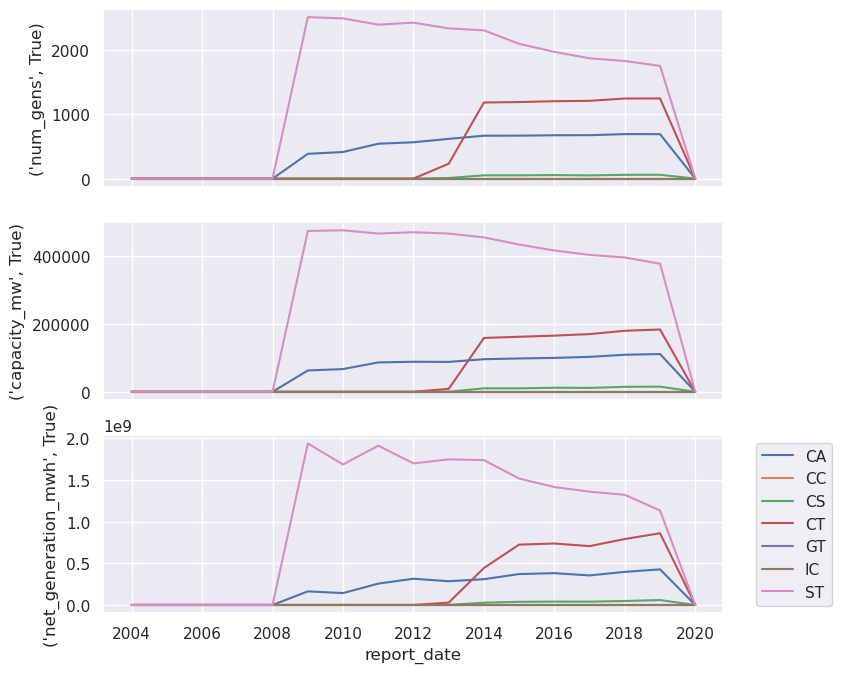

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,8))
sns.lineplot(x="report_date", y=("num_gens", True), data=unit_summary, hue="prime_mover_code", ax=axes[0], legend=False)
sns.lineplot(x="report_date", y=("capacity_mw", True), data=unit_summary, hue="prime_mover_code", ax=axes[1], legend=False)
sns.lineplot(x="report_date", y=("net_generation_mwh", True), data=unit_summary, hue="prime_mover_code", ax=axes[2])
plt.legend(loc="center left", bbox_to_anchor=(1.04, 0.5))
plt.show();

### Proportional Unit Coverage

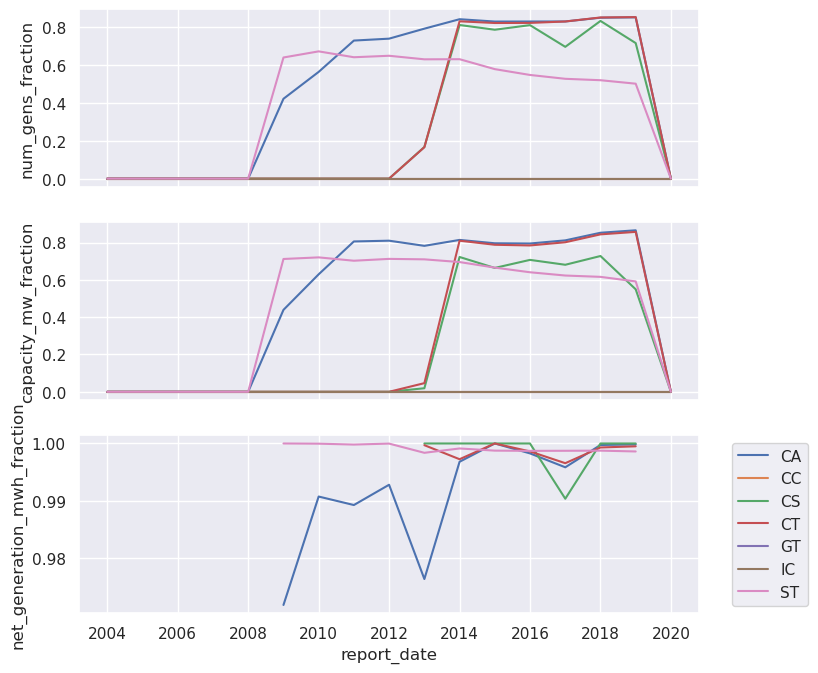

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,8))
sns.lineplot(x="report_date", y="num_gens_fraction", data=unit_summary, hue="prime_mover_code", ax=axes[0], legend=False)
sns.lineplot(x="report_date", y="capacity_mw_fraction", data=unit_summary, hue="prime_mover_code", ax=axes[1], legend=False)
sns.lineplot(x="report_date", y="net_generation_mwh_fraction", data=unit_summary, hue="prime_mover_code", ax=axes[2])
plt.legend(loc="center left", bbox_to_anchor=(1.04, 0.5))
plt.show();

# Improve PUDL Unit ID Coverage

## Fill in missing BGA units
* Many cases in which generation units didn't report completely (esp. before 2014)
* However, often the boiler & generator IDs and associations appear to be the same.
* We can back/forward fill the boiler IDs prior to the BGA process, and get consistent units across all years.
* Can also back/forward fill boiler IDs and unit IDs after the fact and *should* get the same result.
* This will address many currently "boilerless" CCNG units which have use generator ID as boiler ID in latter years.
* We could try and apply this more generally, but in the cases of generator IDs that haven't been used as boiler IDs, it would break the FK relationship with the boiler table, unless we added them there too, which seems like a lot of muddling


In [31]:
gens_eia860 = pudl_out.gens_eia860()
gen_units_are_unique(gens_eia860)

gens_filled = fill_unit_ids(pudl_out)
gen_units_are_unique(gens_filled)

## Identify & assign new Unit IDs

### Simple Complete Combined Cycle Units
* Any single-shaft Combined Cycle generator (CS -- always single-gen)
  * There are a few hundred of these w/o unit_id_pudl values.
  * Each one corresponds to a single unique (plant_id_eia, generator_id).
* Any whole Combined Cycle generator (CC -- always single-gen)
  * These are "generators" for which the combustion & steam turbines co-report.

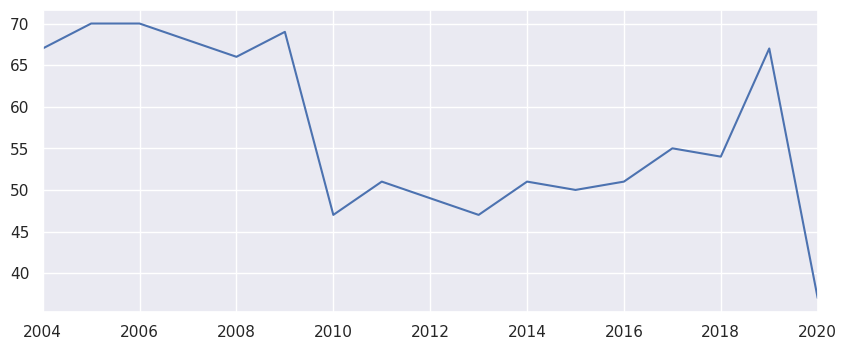

In [66]:
gens_filled[
    (gens_filled.prime_mover_code.isin(["CC", "CS"]))
    & (gens_filled.unit_id_pudl.isna())
].report_date.value_counts().sort_index().plot();

In [80]:
cc_gb = (
    gens_filled[
        (gens_filled.prime_mover_code=="CC")
        & (gens_filled.unit_id_pudl.isna())
    ]
    .loc[:,gen_ids]
    .drop_duplicates().groupby("plant_id_eia")
)
cc_unit_ids = cc_gb.cumcount()+1
gens_filled.loc[cc_unit_ids.index]

,report_date,plant_id_eia,generator_id,unit_id_pudl,prime_mover_code,bga_source
403341,2004-01-01,228,8,<NA>,CC,<NA>
402469,2004-01-01,621,5CC,<NA>,CC,<NA>
398289,2004-01-01,2491,1,<NA>,CC,<NA>
395183,2004-01-01,6043,5CC,<NA>,CC,<NA>
395181,2004-01-01,6043,6CC,<NA>,CC,<NA>
393906,2004-01-01,7242,6,<NA>,CC,<NA>
393834,2004-01-01,7302,3,<NA>,CC,<NA>
393833,2004-01-01,7302,4,<NA>,CC,<NA>
393832,2004-01-01,7302,5,<NA>,CC,<NA>
393831,2004-01-01,7302,6,<NA>,CC,<NA>


In [147]:
wtf = inconsistent_gen_ids(pudl_out)

Found 40 inconsistently reported generator_id values.


<ipython-input-146-75994616ee01>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_gen_id=lambda x: x.generator_id.str.upper().str.replace(r"[^a-zA-Z0-9]", ""),


In [148]:
wtf

,plant_id_eia,generator_id,clean_gen_id
396102,3737,IC5,IC5
336414,3737,IC-5,IC5
396101,3737,IC6,IC6
336413,3737,IC-6,IC6
396100,3737,IC7,IC7
336412,3737,IC-7,IC7
396099,3737,IC8,IC8
336411,3737,IC-8,IC8
373990,7539,CCe1,CCE1
354114,7539,CCE1,CCE1


In [138]:
dude = (
    gens_eia860.set_index(gen_ids)
    .loc[changed.set_index(["plant_id_eia", "generator_id"]).index]
    .reset_index()
    .loc[:,["report_date", "plant_id_eia", "generator_id"]]
)
dude.head(100)

,report_date,plant_id_eia,generator_id
0,2004-01-01,3737,IC5
1,2005-01-01,3737,IC5
2,2006-01-01,3737,IC5
3,2007-01-01,3737,IC5
4,2008-01-01,3737,IC5
5,2009-01-01,3737,IC5
6,2010-01-01,3737,IC5
7,2011-01-01,3737,IC5
8,2012-01-01,3737,IC5
9,2013-01-01,3737,IC5


In [141]:
gens_eia860[
    (gens_eia860.plant_id_eia==3737)
    & (gens_eia860.generator_id.isin(["IC5", "IC-5"]))
]

,report_date,plant_id_eia,plant_id_pudl,plant_name_eia,utility_id_eia,utility_id_pudl,utility_name_eia,generator_id,associated_combined_heat_power,balancing_authority_code_eia,balancing_authority_name_eia,bga_source,bypass_heat_recovery,capacity_mw,carbon_capture,city,cofire_fuels,county,current_planned_operating_date,data_source,deliver_power_transgrid,distributed_generation,duct_burners,energy_source_1_transport_1,energy_source_1_transport_2,energy_source_1_transport_3,energy_source_2_transport_1,energy_source_2_transport_2,energy_source_2_transport_3,energy_source_code_1,energy_source_code_2,energy_source_code_3,energy_source_code_4,energy_source_code_5,energy_source_code_6,ferc_cogen_status,ferc_exempt_wholesale_generator,ferc_small_power_producer,fluidized_bed_tech,fuel_type_code_pudl,fuel_type_count,grid_voltage_2_kv,grid_voltage_3_kv,grid_voltage_kv,iso_rto_code,latitude,longitude,minimum_load_mw,multiple_fuels,nameplate_power_factor,...,planned_modifications,planned_net_summer_capacity_derate_mw,planned_net_summer_capacity_uprate_mw,planned_net_winter_capacity_derate_mw,planned_net_winter_capacity_uprate_mw,planned_new_capacity_mw,planned_new_prime_mover_code,planned_repower_date,planned_retirement_date,planned_uprate_date,previously_canceled,primary_purpose_naics_id,prime_mover_code,pulverized_coal_tech,reactive_power_output_mvar,retirement_date,rto_iso_lmp_node_id,rto_iso_location_wholesale_reporting_id,sector_id,sector_name,service_area,solid_fuel_gasification,startup_source_code_1,startup_source_code_2,startup_source_code_3,startup_source_code_4,state,stoker_tech,street_address,subcritical_tech,summer_capacity_estimate,summer_capacity_mw,summer_estimated_capability_mw,supercritical_tech,switch_oil_gas,syncronized_transmission_grid,technology_description,time_cold_shutdown_full_load_code,timezone,topping_bottoming_code,turbines_inverters_hydrokinetics,turbines_num,ultrasupercritical_tech,unit_id_pudl,uprate_derate_completed_date,uprate_derate_during_year,winter_capacity_estimate,winter_capacity_mw,winter_estimated_capability_mw,zip_code
396102,2004-01-01,3737,727,Essex Junction 19,7601,128,Green Mountain Power Corp,IC5,False,ISNE,ISO New England Inc.,NaN,False,1.0,None,Essex Junction,None,Chittenden,None,None,True,True,False,truck,None,None,None,None,None,DFO,None,None,None,None,None,False,False,False,None,oil,2,NaN,NaN,34.5,ISONE,44.4821,-73.1164,NaN,None,NaN,...,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,22.0,IC,None,0.25,None,None,None,1.0,Electric Utility,None,False,None,None,None,None,VT,None,111 Park Street,None,None,1.1,NaN,None,None,None,None,None,America/New_York,X,None,0.0,None,<NA>,None,None,None,1.0,NaN,05452
376572,2005-01-01,3737,727,Essex Junction 19,7601,128,Green Mountain Power Corp,IC5,False,ISNE,ISO New England Inc.,NaN,False,1.0,None,Essex Junction,None,Chittenden,None,None,True,True,False,truck,None,None,None,None,None,DFO,None,None,None,None,None,False,False,False,None,oil,2,NaN,NaN,34.5,ISONE,44.4821,-73.1164,NaN,None,NaN,...,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,22.0,IC,None,0.25,None,None,None,1.0,Electric Utility,None,False,None,None,None,None,VT,None,111 Park Street,None,None,1.1,NaN,None,None,None,None,None,America/New_York,X,None,0.0,None,<NA>,None,None,None,1.0,NaN,05452
356730,2006-01-01,3737,727,Essex Junction 19,7601,128,Green Mountain Power Corp,IC5,False,ISNE,ISO New England Inc.,NaN,False,1.0,None,Essex Junction,None,Chittenden,None,None,True,True,False,truck,None,None,None,None,None,DFO,None,None,None,None,None,False,False,False,None,oil,2,NaN,NaN,34.5,ISONE,44.4821,-73.1164,NaN,False,NaN,...,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,22.0,IC,None,0.25,None,None,None,1.0,Electric Utility,None,False,None,None,None,None,VT,None,111 Park Street,None,False,1.1,NaN,None,None,None,None,None,America/New_York,X,None,0.0,None,<NA>,None,None,False,1.0,NaN,05452
336414,2007-01-01,3737,727,Essex Junction 19,7601,128,Green Mountain Power Corp,IC-5,False,ISNE,ISO New 

### Aggregated Unique Combined Cycle Units
* For any plant that contains both CA and CT generators,
* and **only** has a signle CA **or** a single CT,
* all the CA and CT generators must be part of the same unit.

<AxesSubplot:>

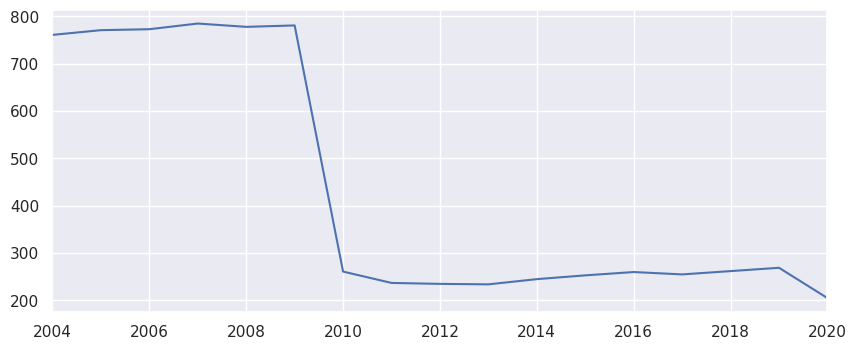

In [65]:
gens_filled[
    (gens_filled.prime_mover_code.isin(["CA", "CT"]))
    & (gens_filled.unit_id_pudl.isna())
].report_date.value_counts().sort_index().plot()

### Aggregated Complex Combined Cycle Units
* For any plant that contains more than one CA and more than one CT,
* we cannot distinguish which ones are connected to each other,
* thus they must all be aggregated into a single unit.

### Generic Unique Units
* For any plant containing only a single generator lacking a unit_id_pudl
* That generator can be considered a standalone unit.

## Assess New Unit ID Impacts on coverage
* Run the same assessment functions as we did above

## Additional Unit ID Notes:
* What is the output table describing these units going to look like?
* Should it be several different well normalized tables defining different kinds of Unit IDs?
* Should it be a single un-normalized table?
* Need to break out Steam Turbines (prime_mover_code=="ST") are associated with coal, geothermal, nuclear, maybe gas as well.
* Should we backfill the technology description to older years?
* Organize process by prime mover type
* Merge prime movers with bga
* Should we fill in pseudo-boiler IDs for the units that we've created, like the latter years of CCNG plants do?

In [ ]:
assert False

# Combined Heat and Power
* What fraction of generators, capacity, and generation are associated with generators that also do CHP?

In [ ]:
chp_summary = chp_prevalence(prepped_gens)
chp_summary

# Assess Existing Heat Rates
* We need some way to compare different ways of calculating heat rates and choose between them.
* We want to check both for their correctness, and their completeness.
* Apparent correctness will depend on the type of generator / unit type. Need to define different expectations.

In [ ]:
%%time
hr_by_unit = pudl_out.hr_by_unit()
hr_by_unit.info()

## Compile Net Generation
* **By generator**
  * `net_generation_mwh` available from `generation_eia923` table
  * Associated with `plant_id_eia` and `generator_id` columns directly.
  * Can be associated with `unit_id_pudl` if the generator is part of an identified unit
  * Can be associated with a `technology_description` and `prime_mover_code` based on the `generators_eia860` table.
  * Can be associated with a list of energy sources based on `energy_source_N` in `generators_eia860` table.
* **By plant-prime-fuel**
  * `net_generation_mwh` is available from generation_fuel_eia923`

## Compile Fuel Consumption
* **By boiler**
  * `total_heat_content_mmbtu` and `fuel_type_code_pudl` are available by `plant_id_eia` and `boiler_id` in `boiler_fuel_eia923`
  * This value can be be associated with a `unit_id_pudl` based on the BGA table.
  * The heat consumed in here includes fuels both for electricity and steam (direct heat) outputs.
* **By plant-prime-fuel**
  * Available in `generation_fuel` and broken down as for CHP vs Electricity separately.

## Identify Combined Cycle Units
* Combined Cycle turbines show up in the generators table, but have no "boiler" so they don't end up in the boiler-generator-association
* This means they don't get assigned `unit_id_pudl` values and are often lost.
* However, they are identifiable based on `technology_description` in the generators table, and so can be associated with a plant.
* Within a given plant, it's possible to combine all the natural gas that goes into a 

## Questions:
* Do all of the generators that show up in the generation table end up getting PUDL Unit IDs assigned?
* Where are the heat inputs being reported for combined cycle units? Do they really exist after 2015? What is still missing?
* Triage units / generators into: Easy, Hard, and Impossible. Work on Hard ones until diminishing returns. Assign impossible and too-hard ones the median values.

## Tables of Interest:
* `generation_eia923`
* `generation_fuel_eia923`
* `boiler_generator_assn_eia860`
* `generators_eia860`
* `generators_entity_eia`
* `boiler_fuel_eia923`

In [ ]:
gens_eia860_sql = """
SELECT report_date,
       plant_id_eia,
       generator_id,
       capacity_mw,
       energy_source_code_1,
       energy_source_code_2,
       energy_source_code_3,
       energy_source_code_4,
       energy_source_code_5,
       energy_source_code_6,
       fuel_type_code_pudl,
       technology_description,
FROM generators_eia860
"""

gens_entity_sql = """
SELECT report_date,
       plant_id_eia,
       generator_id,
       prime_mover_code,
       bypass_heat_recovery,
       associated_combined_heat_and_power,
FROM generators_entity_eia
"""

gen_eia923_sql = """
SELECT report_date,
       plant_id_eia,
       generator_id,
       net_generation_mwh
FROM generation_eia923
"""

gf_eia923_sql = """
SELECT report_date,
       plant_id_eia,
       nuclear_unit_id,
       fuel_type,
       fuel_type_code_pudl,
       prime_mover_code,
       fuel_consumed_mmbtu,
       fuel_consumed_for_electricity_mmbtu,
       net_generation_mwh
FROM generation_fuel_eia923
"""

bga_sql = """
SELECT report_date,
       plant_id_eia,
       unit_id_pudl,
       generator_id,
       boiler_id
FROM boiler_generator_assn_eia860
"""

bf_eia923_sql = """
SELECT report_date,
       plant_id_eia,
       boiler_id,
       fuel_type_code,
       fuel_type_code_pudl,
       fuel_consumed_units,
       fuel_mmbtu_per_unit
FROM boiler_fuel_eia923
"""


## Compile Fuel Consumption
  * Reported by boiler in `boiler_fuel_eia923` and so can be associated 

# Preliminary Data Wrangling
Once all of the data is loaded and looks like it's in good shape, do any initial wrangling that's specific to this particular analysis. This should mostly make use of the higher level functions which were defined above. If this step takes a while, don't be shy about producing `logging` outputs.

# Data Analysis and Visualization
* Now that you've got the required data in a usable form, you can tell the story of your analysis through a mix of visualizations, and further data wrangling steps.
* This narrative should be readable, with figures that have titles, legends, and labeled axes as appropriate so others can understand what you're showing them.
* The code should be concise and make use of the parameters and functions which you've defined above when possible. Functions should contain comprehensible chunks of work that make sense as one step in the story of the analysis.

In [ ]:
coal_ax = finite_distplot(mcoe_coal, "heat_rate_mmbtu_mwh", max_val=20)
plt.title("Coal heat rate distribution");

In [ ]:
gas_ax = finite_distplot(mcoe_gas, "heat_rate_mmbtu_mwh", max_val=20)
plt.title("Gas heat rate distribution");